In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
# from vespa.predict.logodds import *
# import vespa.predict.utils as vespa_utils

(16894, 33)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'pred'],
      dtype='object')


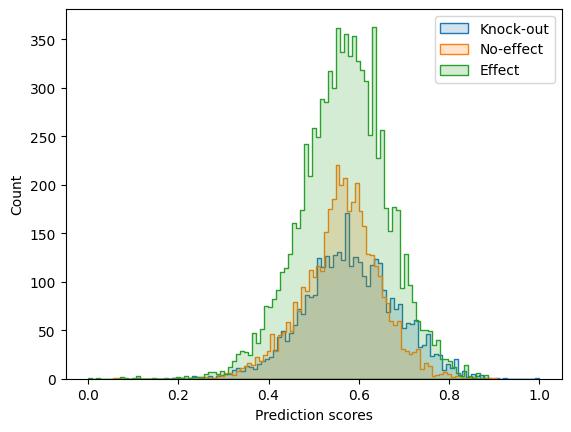

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    # sns.histplot(result_df, x="pred", y="class", element="step", hue="class", bins=bins, alpha=0.2)
    
    plt.legend()
    plt.xlabel("Prediction scores")
    plt.ylabel("Count")
    plt.show()

result_df = pd.read_csv(home_dir+f"models/vespa_marquet/outputs/vespa/pmd/preds_vespa_mt.tsv", sep="\t")
result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
model_pred_col = "pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
# result_df["pred"]=result_df[model_pred_col]
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()
plot_distribution(result_df, n_samples=None)

In [2]:
cache_dir=home_dir+"models/vespa_marquet/cache"
t5_condProbas = T5_condProbas(cache_dir=cache_dir)
model, tokenizer = t5_condProbas.prott5.get_model(1) #1=LOGODDS

In [11]:
seq = "AMVNSTHR" # eos token added
seq = " ".join(list(seq))
model.to("cpu")
input_ids = tokenizer(seq, return_tensors="pt").input_ids.to("cpu")
print(input_ids)
with torch.no_grad():  # only logits is useful for us
    logits = model(input_ids, labels=input_ids).logits
    logits = logits[0].detach().numpy() 

print(logits.shape)

tensor([[ 3, 19,  6, 17,  7, 11, 20,  8,  1]])
(9, 128)


In [14]:
tokenizer.convert_tokens_to_ids("▁V")

6

In [9]:
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta")) # this replaces the unknown amino acids UZO, not B
print(len(seq_dict))
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
seq

11714


'MVNSTHRGMHTSLHLWNRSSYRLHSNASESLGKGYSDGGCYEQLFVSPEVFVTLGVISLLENILVIVAIAKNKNLHSPMYFFICSLAVADMLVSVSNGSETIVITLLNSTDTDAQSFTVNIDNVIDSVICSSLLASICSLLSIAVDRYFTIFYALQYHNIMTVKRVGIIISCIWAACTVSGILFIIYSDSSAVIICLITMFFTMLALMASLYVHMFLMARLHIKRIAVLPGTGAIRQGANMKGAITLTILIGVFVVCWAPFFLHLIFYISCPQNPYCVCFMSHFNLYLILIMCNSIIDPLIYALRSQELRKTFKEIICCYPLGGLCDLSSRY'

In [17]:
a_prot_seq = protid_seq_dict_list[0]
csv_dir = home_dir+"models/vespa_marquet/outputs/vespa/lm_outputs"
mutation_gen = vespa_utils.MutationGenerator(sequence_dict=a_prot_seq)
proba_dict = t5_condProbas.get_proba_dict(a_prot_seq, mutation_gen)
dmiss_data = t5_condProbas.get_log_odds(proba_dict)
T5_condProbas.write_csv_dir(dmiss_data, csv_dir, mutation_gen)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.76 GiB total capacity; 9.02 GiB already allocated; 17.75 MiB free; 9.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
import re
seq = "CUDA"
re.sub(r"[UZOB]", "X", seq)

'CXDA'

In [ ]:
import vespa.predict.utils as vespa_utils
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta"))
print(len(seq_dict))
# protid_seq_dict_list = [{prot_id: seq} for prot_id, seq in  seq_dict.items()]
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
print(protid, seq)